In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['diamonds.csv']


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
import xgboost as xgb
from category_encoders.ordinal import OrdinalEncoder
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn_pandas import DataFrameMapper
import numpy as np

In [3]:
#Get data:
file_path = '../input/diamonds.csv'

df = pd.read_csv(file_path,index_col =0)


In [4]:
# Check for completness of dataset: No null entires!
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


In [5]:
# Print .head() to get a flavour of the dataset:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


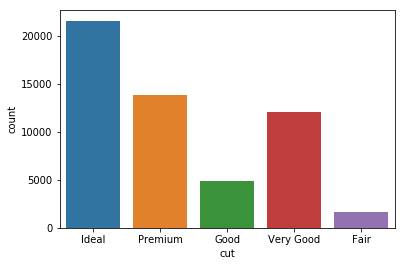

In [6]:
# Count the types of cut: Ideal and premium cuts are most popular
sns.countplot(df.cut)

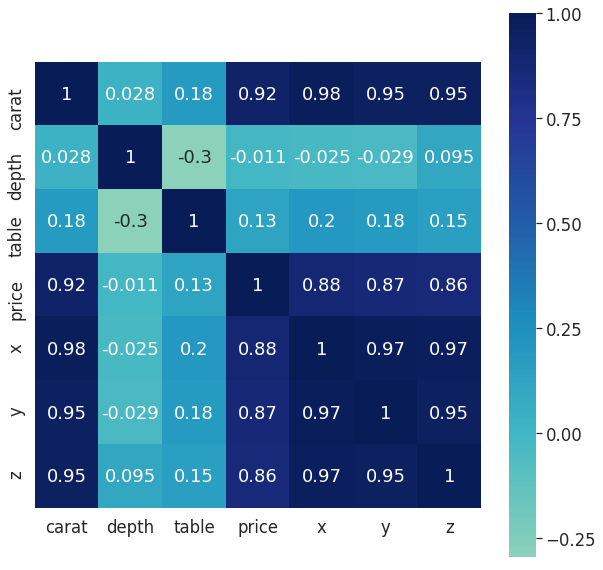

In [7]:
# In order to do any feature engineering before building the model
# Its usually a good idea to see which attributes strongly correlated with Price
# Correlation:
df_numeric = df.select_dtypes(exclude=['object'])
df_corr = df_numeric.corr()
plt.figure(figsize=(10,10))
#Heatmap:
sns.set(font_scale=1.5)
sns.heatmap(df_corr,center=0,cmap='YlGnBu',square=True, annot=True)

#Carat is correlated the most, although x,y,z are not far behind.

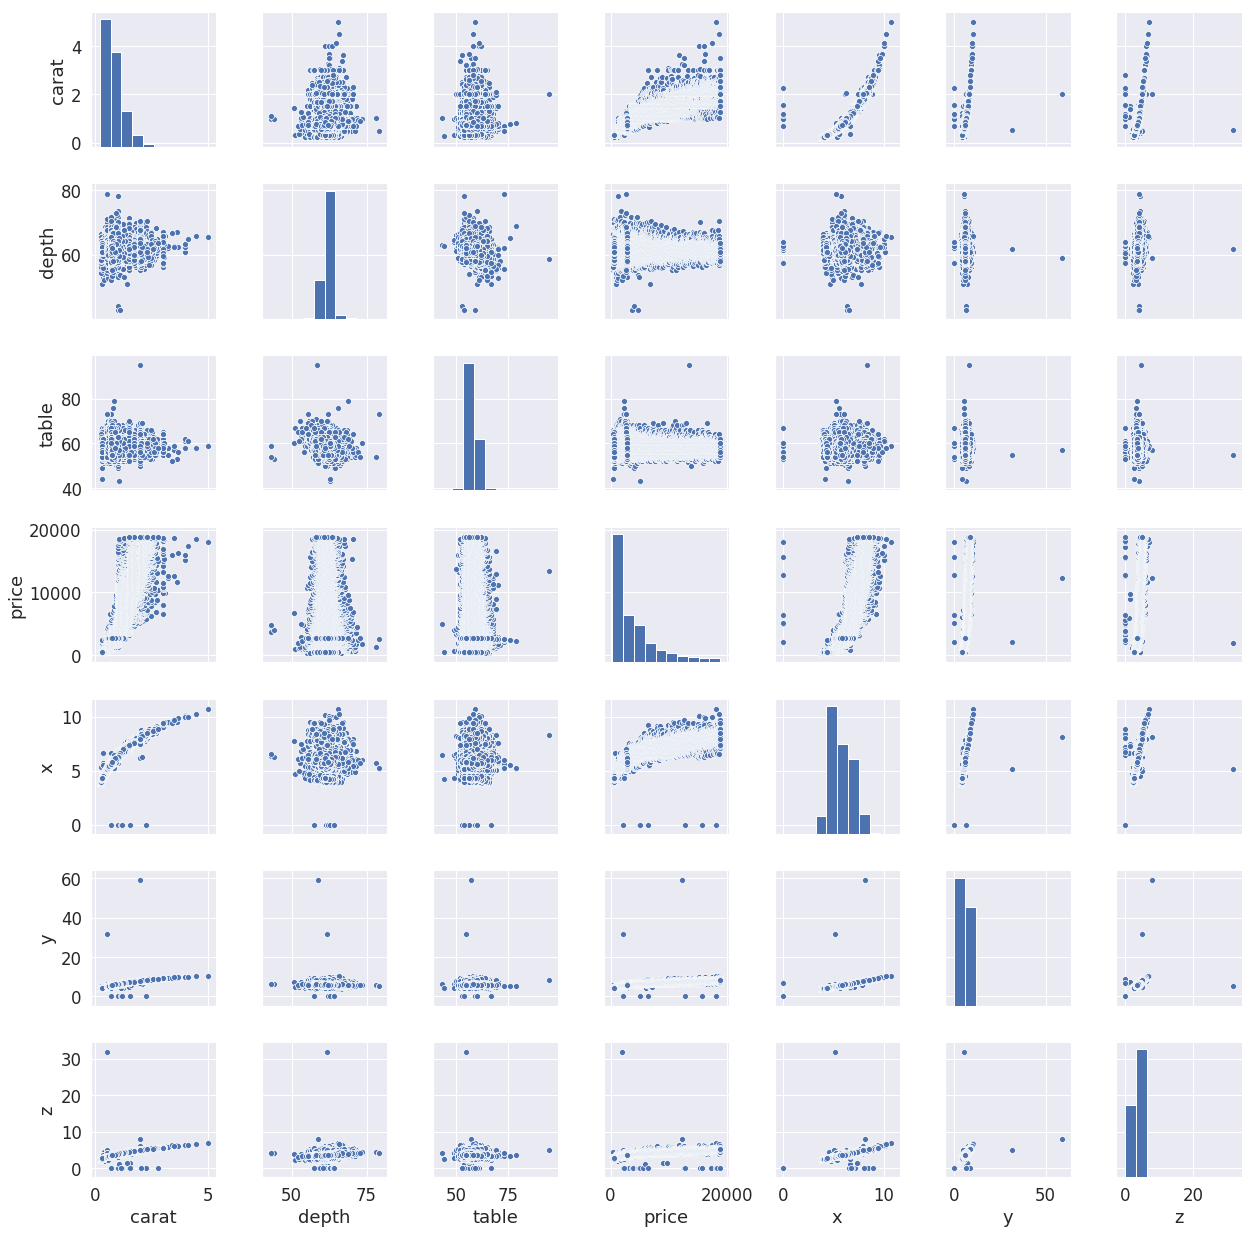

In [8]:
sns.pairplot(df)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


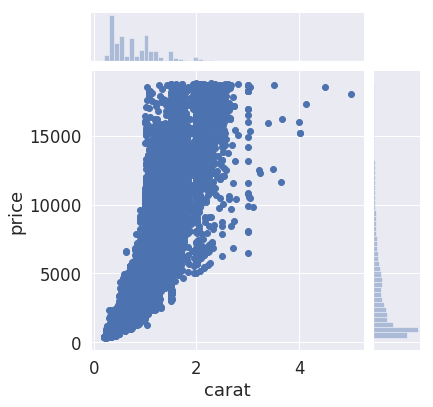

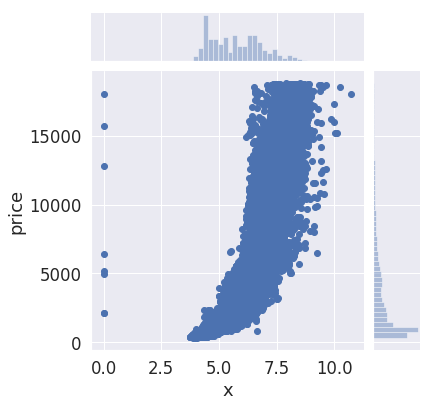

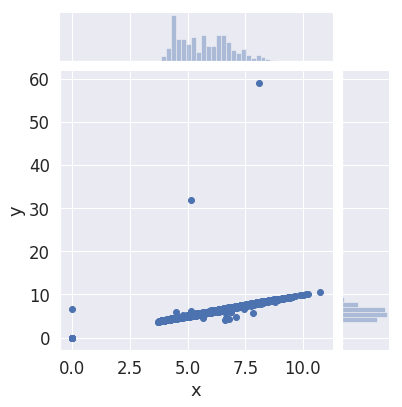

In [9]:
# Note: We want to maybe create new features such as ratio of carat to length
# Ratio of length to width
# See if any of the above also correlate with price
# But before we can do that you may notice x,y,z suffer from zero values
# We don't want to divide by zero!
sns.jointplot(x='carat',y='price',data=df)
sns.jointplot(x='x',y='price',data=df)
sns.jointplot(x='x',y='y',data=df)

In [10]:
# We have value where length=0,width=0,depth=0. Remove this before feature engineering otherwise we divide by 0 and get inf:
print((df.x == 0).any())
print((df.y == 0).any())
print((df.z == 0).any())

True
True
True


In [11]:
#Delete each row with this condition:
df = df[df['x']!= 0]
df = df[df['y']!= 0]
df = df[df['z']!= 0]

In [12]:
# Feature engineering: Length to width ratio, carat/x,carat,y,carat/z
df = df.assign(length_width_ratio = round(df.x/df.y,2))
df = df.assign(carat_length_ratio = round(df.carat/df.x,2))
df = df.assign(carat_width_ratio = round(df.carat/df.y,2))
df = df.assign(carat_depth_ratio = round(df.carat/df.z,2))

In [13]:
# Now check updated correlations with price:
# length to width ratio has little correlation but the resut are very highly correlated!
df_corr = df.corr()
df_corr['price']

carat                 0.921592
depth                -0.010729
table                 0.127245
price                 1.000000
x                     0.887231
y                     0.867864
z                     0.868206
length_width_ratio    0.079758
carat_length_ratio    0.904493
carat_width_ratio     0.903192
carat_depth_ratio     0.906254
Name: price, dtype: float64

In [14]:
# Before we go anyfurther into preprocessing its good practice to reserve a holdout set for testing
# We will return to this later!
diamond_train,diamond_test = train_test_split(df,test_size=0.2)

In [15]:
# Good idea now is to only work with our training data and start the preprocessing stage
# X=features, y=target
X,y = diamond_train.drop('price',axis=1),diamond_train.price


In [16]:
# This section we will attempt to use OrdinalEncoder() which can be customerised so that I can specify what each class in each attribute should be labeled as.
# We will also standardize our numerical attributes before inputing into our model (standard ML practice).

# List of dictionaries, first key should be the feature name, second key should be mapping.

ordinal_enc_mapping = [{'col':'cut','mapping': [('Fair',0),('Good',1),('Very Good',2),('Premium',3),('Ideal',4)]},
                       {'col':'color','mapping': [('J',0),('I',1),('H',2),('G',3),('F',4),('E',5),('D',6)]},
                       {'col':'clarity','mapping': [('I1',0),('SI2',1),('SI1',2),('VS2',3),('VS1',4),('VVS2',5),('VVS1',6),('IF',7)]}]

# Seperate categorical columns from numerical:
categorical_columns = list(X.select_dtypes(include=['object']).columns)
numerical_columns = list(X.select_dtypes(exclude=['object']).columns)

#Dataframemapper: Useful for applying transformation to specific columns of the dataframe.
#numeric_mapper will apply transforms to the numeric columns selected above. First element in tuple is a list of columns to apply transformation to and second element is transformation.
numeric_mapper = DataFrameMapper([([numeric_feature], StandardScaler()) for numeric_feature in numerical_columns],
                                sparse=False, df_out=True,input_df=True)


#Apply feature union to both dataframe mapper and OrdinalEncoder:

numerical_categorical_union = FeatureUnion([('num_mapper',numeric_mapper),('oe',OrdinalEncoder(mapping=ordinal_enc_mapping,cols=categorical_columns))])

In [17]:
# Now we setup a Pipeline to run this badboy in! 
# Piece together into a pipeline: I have set the n_estimators high, rarely do we have an issue with overfitting on XGBoost if we keep the learning rate at a sufficient level.
steps = [('featureunion',numerical_categorical_union),
         ('xgb_model',xgb.XGBRegressor(n_estimators=1000,subsample=0.3,max_depth=10,learning_rate=0.005,gamma=1.45))]

pipeline = Pipeline(steps)

In [18]:
#cross validate: 3 folds
cv = cross_val_score(pipeline,X,y,cv=3,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.4min finished


In [19]:
#R2 score: Average of 3 folds
print(cv.mean())

0.9825156564551604


In [20]:
# Now to the above performs well on the training data, lets check the test data with 3 folds:
X_test,y_test = diamond_test.drop('price',axis=1),diamond_test.price

cv_test = cross_val_score(pipeline,X_test,y_test,scoring='r2',cv=3)

#R2 score:
print('R2 score:',cv_test.mean())

R2 score: 0.9801095327230485
